c:\Users\bjsb\OneDrive - NRGi A S\Gammelt H drev\PhD\Kurser\46750 Optimization in Power Systems\Assignment2group28\46750_g28_Assignment_2\src\data_loader.py:193: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df[selected_col].resample(resample_method).sum()


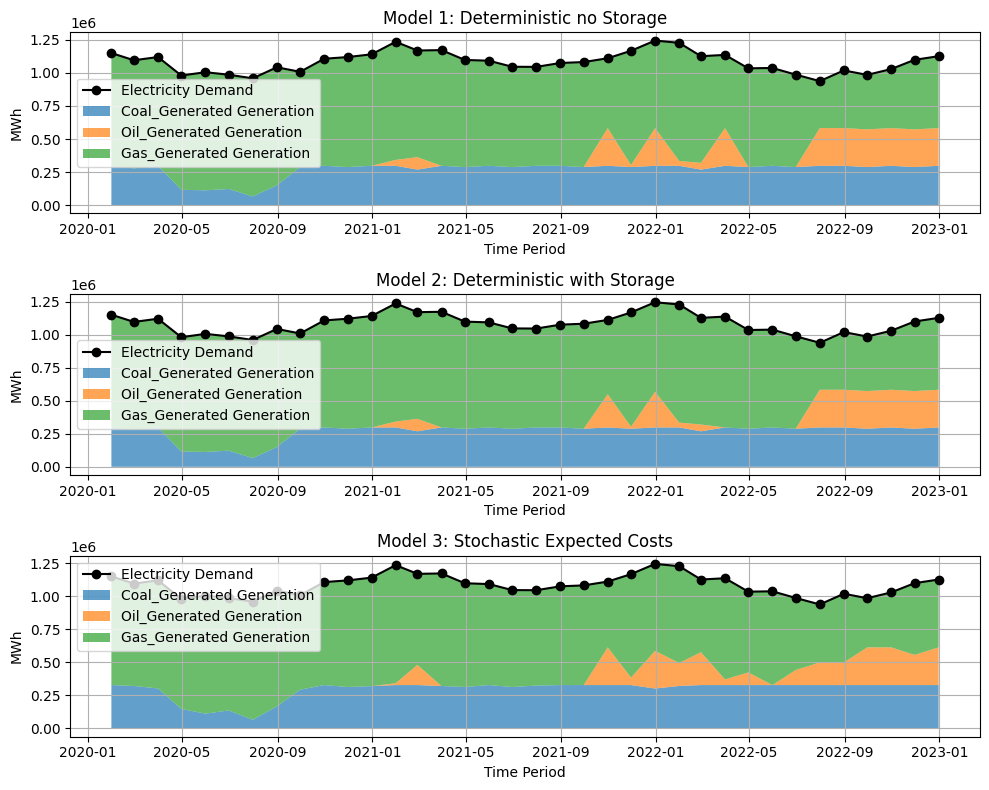

In [ ]:
import os
from pathlib import Path
from data_loader import load_prices, load_storage, load_efficiency, load_plant_capacity, load_demand
import pandas as pd
import matplotlib.pyplot as plt

# Data Loading from data folder in the parent directory
current_dir = Path().resolve()
data_folder = os.path.join(current_dir.parent, "data")
# fuel_prices_file = os.path.join(data_folder, "fuel_prices.csv")            # Price in EUR/tonne (coal,oil) or EUR/m3 (gas)
# storage_file = os.path.join(data_folder, "storage.csv")                    # Max storage in tonnes/m3
# efficiency_file = os.path.join(data_folder, "efficiency.csv")              # efficiency of MWh th to MWh el
# plant_file = os.path.join(data_folder, "plant_capacity.csv")               # Plant capacity in MWh/month
demand_file = os.path.join(data_folder, "electricity_demand.csv")          # Monthly demand in MWh

# For comparison with previous model, we must use the same parameters
start_date = "2020-01"
end_date = "2022-12"
fuels = ["coal", "oil", "gas"]
zone = 'DK_1'  # Specify the zone for demand data
resample_method = 'M' # Monthly resampling 

try:
    # fuel_prices_df = load_prices(fuel_prices_file, start_date, end_date, resample_method= resample_method)
    # storage = load_storage(storage_file)
    # efficiency = load_efficiency(efficiency_file)
    # plant_capacity = load_plant_capacity(plant_file)
    demand_df = load_demand(demand_file, start_date, end_date, resample_method= resample_method ,zone=zone ,supply_factor=0.6)
except Exception as e:
    raise RuntimeError(f"Error loading data: {e}")

# Read in the proper DataFrames  for plotting (based on running-cost CSVs)
base_df = pd.read_csv(os.path.join(current_dir.parent, "results", "model1", "model1_results.csv"), parse_dates=["Month"],
                      index_col="Month")
det_df = pd.read_csv(os.path.join(current_dir.parent, "results", "model2", "model2_results.csv"), parse_dates=["Month"],
                     index_col="Month")
exp_df = pd.read_csv(os.path.join(current_dir.parent, "results", "model3", "stochastic_expected_running_costs.csv"),
                     parse_dates=["Month"], index_col="Month")

# Generated energy columns based on fuel types
G = [fuel_g for fuel_g in base_df.columns if fuel_g.endswith('_Generated')]

# Plot demand over time employing fill_between to show contributions from each fuel with each model in a subplot
plt.figure(figsize=(10, 8))
for i, (df, title) in enumerate(zip([base_df, det_df, exp_df],
                                    ['Model 1: Deterministic no Storage',
                                     'Model 2: Deterministic with Storage',
                                     'Model 3: Stochastic Expected Costs'])):
    plt.subplot(3, 1, i + 1)
    plt.plot(demand_df.index, demand_df[zone], marker='o', label='Electricity Demand', color='black')
    bottom = [0]*len(demand_df)
    for fuel_g in G:
        generation = [df.loc[t,fuel_g] for t in demand_df.index]
        plt.fill_between(demand_df.index, bottom, [b + g for b, g in zip(bottom, generation)], label=f'{fuel_g} Generation', alpha=0.7)
        bottom = [b + g for b, g in zip(bottom, generation)]
    plt.title(title)
    plt.xlabel('Time Period')
    plt.ylabel('MWh')
    plt.legend()
    plt.grid()
plt.tight_layout()
plt.show()
